<a href="https://colab.research.google.com/github/sajadalipour7/MachineLearning-Trainings/blob/master/DeepLearning-using-Tensorgflow/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed for each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data)  so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set(these images have labels)
* There are around 10,000+ images in the test set(these images have no labels, because we'll want to predict them).

In [2]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Make sure we're using a GPU


In [1]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:",tf.__version__)

TF version: 2.3.0


In [2]:
import tensorflow_hub as hub
print("TF Hub version:",hub.__version__)

# Check for GPU availability
print("GPU","available!" if tf.config.list_physical_devices("GPU") else "not available!")

TF Hub version: 0.9.0
GPU available!


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representation)

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     4e8d1cbfa6a477abe4b9e5a2ecbf1818  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


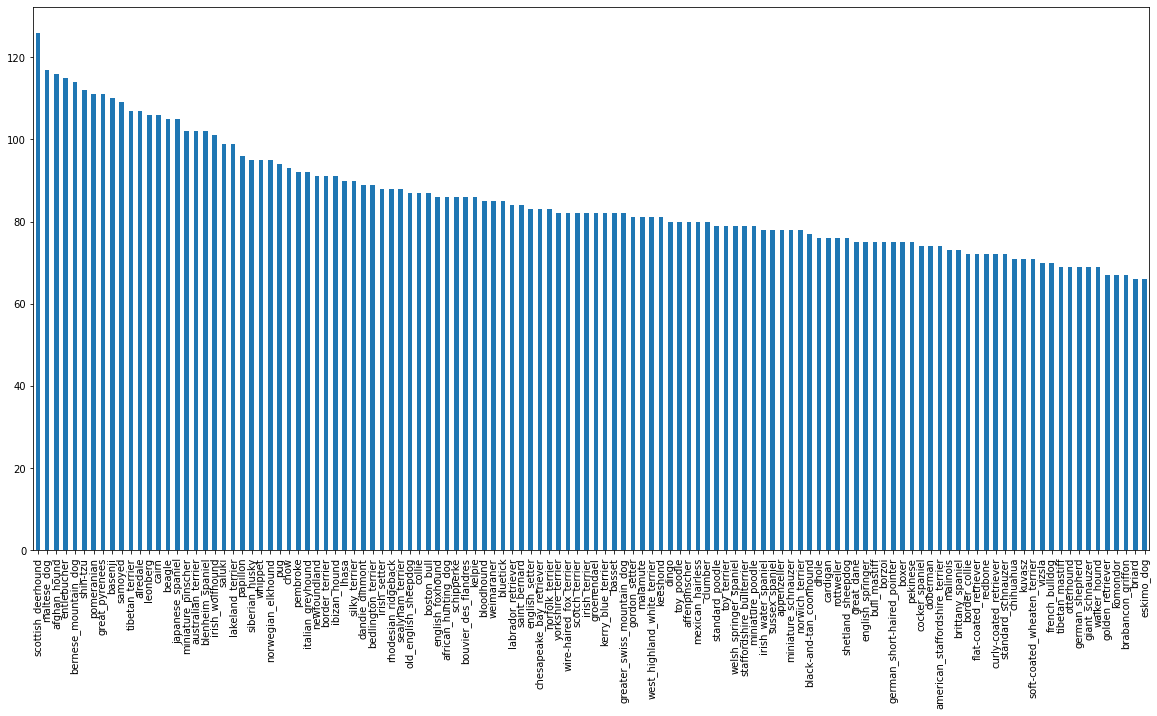

In [6]:
# How many images are there of each bread?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [10]:
labels_csv["breed"].value_counts().median()

82.0

In [8]:
min(labels_csv["breed"].value_counts())

66